In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1.2,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 10, Accuracy: 0.8271604938271605, Loss: 0.7624766031901041
Checkpoint 20, Accuracy: 0.8271604938271605, Loss: 0.7381432851155599
Checkpoint 30, Accuracy: 0.8827160493827161, Loss: 0.691968423348886
Checkpoint 40, Accuracy: 0.8271604938271605, Loss: 0.6637638939751519
Checkpoint 50, Accuracy: 0.8580246913580247, Loss: 0.5963490804036459
Checkpoint 60, Accuracy: 0.845679012345679, Loss: 0.6052568930166738
Checkpoint 70, Accuracy: 0.8580246913580247, Loss: 0.5709364149305556
Checkpoint 80, Accuracy: 0.8950617283950617, Loss: 0.4650058039912471
Checkpoint 90, Accuracy: 0.9135802469135802, Loss: 0.4052988688151042
Checkpoint 100, Accuracy: 0.9506172839506173, Loss: 0.3990315684565791
Checkpoint 110, Accuracy: 0.9382716049382716, Loss: 0.37380285616274234
Checkpoint 120, Accuracy: 0.9259259259259259, Loss: 0.36481299223723235
Checkpoint 130, Accuracy: 0.9320987654320988, Loss: 0.32944099991409864
Checkpoint 140, Accuracy: 0.9444444444444444, Loss: 0.34110048082139754
Checkpoint 15

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.7865386  0.10121319 0.11224817]
[1. 0. 0.] <-> [0.8215978  0.10034849 0.07805368]
[1. 0. 0.] <-> [0.7946643  0.10008771 0.10524797]
[1. 0. 0.] <-> [0.80751526 0.05440979 0.13807504]
[0. 0. 1.] <-> [0.62582654 0.03997849 0.33419496]
[1. 0. 0.] <-> [0.74436426 0.06286587 0.19276991]
[1. 0. 0.] <-> [0.7396774  0.05570741 0.20461518]
[1. 0. 0.] <-> [0.8208285  0.0546336  0.12453794]
[1. 0. 0.] <-> [0.7921923  0.13895811 0.06884965]
[1. 0. 0.] <-> [0.81908065 0.06534862 0.11557078]
[0. 0. 1.] <-> [0.78778404 0.03588184 0.17633408]
[1. 0. 0.] <-> [0.7095098  0.05496874 0.23552147]
[1. 0. 0.] <-> [0.8326676  0.05217395 0.11515848]
[0. 1. 0.] <-> [0.54745454 0.42298287 0.02956254]
[0. 0. 1.] <-> [0.1783086  0.03197091 0.78972054]
[1. 0. 0.] <-> [0.7667283  0.18759899 0.04567273]
[1. 0. 0.] <-> [0.7327008  0.07001615 0.197283  ]
[1. 0. 0.] <-> [0.8331378  0.08004104 0.08682116]
[1. 0. 0.] <-> [0.7605408  0.1788812  0.06057802]
[1. 0. 0.] <-> [0.7403469  0.123288   0.13636515]


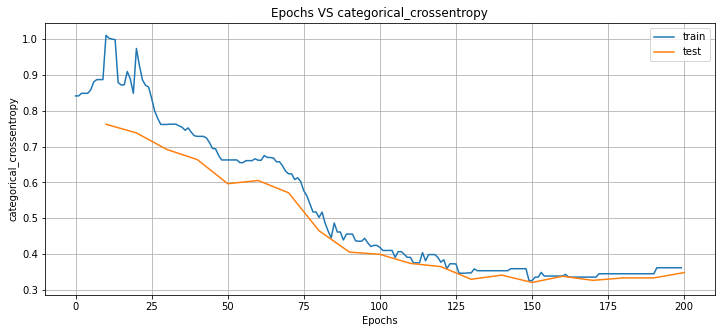

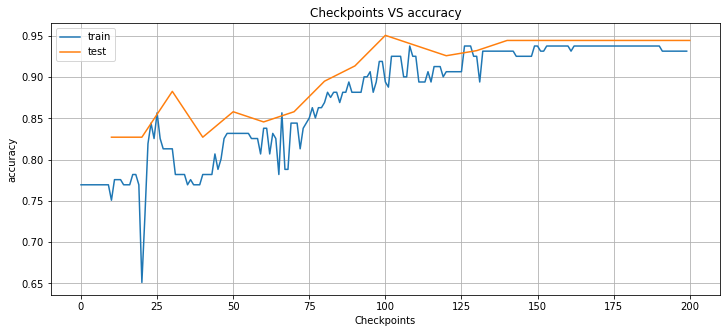

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8271604938271605, 'mean_square_error': 0.4147297521287658, 'categorical_crossentropy': 0.7624766031901041, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 28, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 10} 


{'accuracy': 0.8271604938271605, 'mean_square_error': 0.4093102658960149, 'categorical_crossentropy': 0.7381432851155599, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 28, 'tn_hit': 0, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 20} 


{'accuracy': 0.8827160493827161, 'mean_square_error': 0.3842144016422221, 'categorical_crossentropy': 0.691968423348886, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 19, 'tn_hit': 9, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit':

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.5107987   1.0174161   0.5826567  -0.01094864 -0.45452753]
 bias: -0.3497839570045471

Neuron 1: weights:
[ 0.5903092  -0.7047977  -0.31386876  0.35431927  0.761035  ]
 bias: -0.6589184999465942

Neuron 2: weights:
[ 0.38540033 -1.0422219  -0.709954   -0.639898   -0.26298788]
 bias: 0.47397035360336304

Neuron 3: weights:
[-0.39273763  0.59160894  0.3286483  -0.5725031  -0.8086867 ]
 bias: 0.3754011392593384

$
Layer 2
Neuron 0: weights:
[-0.28750527 -0.6756632   1.4483806   0.55774903]
 bias: 0.10298486053943634

Neuron 1: weights:
[ 1.3947891 -0.8371103 -1.6210564  0.7400501]
 bias: -0.31227001547813416

Neuron 2: weights:
[-0.7375835   1.5978471  -0.14318493 -1.7609113 ]
 bias: -0.07480961084365845

$

